# FRED Overview

In order to programatically request data from FRED, you first need to first request an api key from the
[FRED website](https://fred.stlouisfed.org/docs/api/api_key.html). After you have done so, you'll  have the ability to request data from FRED via python. The python package I 
have always used is [fredapi](https://github.com/mortada/fredapi). There isn't any special reason why I chose this package over the other ones I have seen, but it was the first one I encountered a long time ago and it hasn't failed me yet, so I have felt no urge to change.


In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
import xlwings as xw
import yaml
from typing import List, Dict, Tuple, Optional, Union, Callable, Any, Iterable

# Bunch of matplotlib setup
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [14, 8]



from matplotlib.ticker import FuncFormatter
def percentage_formatter(x, pos):
    ''' Formats the y-axis labels as percentages. '''
    return f'{x:.1%}'

ALTAFID_COLORS = [
        "#3f4c60",
        "#93c9f9",
        "#94045b",
        "#83889d",
        "#ffc000",
        "#386f98",
        "#9dabd3",
        "#b80571",
        "#45ad35",
        "#b38825",
        "#525e70",
        "#98bbdc",
        "#aa6597",
        "#6abd5d",
        "#716920",
    ]  
def set_mpl_colors() -> None:
    import matplotlib as mpl
    from cycler import cycler


    mpl.rcParams["axes.prop_cycle"] = cycler(color=ALTAFID_COLORS)
set_mpl_colors()

## Establishing a FRED object
Step one when using FRED is to import the package and establish a master "fred" object. The fred object is the primary work horse and will be doing most of the heavy lifting. 

In [25]:
from fredapi import Fred

# Load in api from config file
with open('secrets.yml') as f:
    secrets = yaml.safe_load(f)


fred = Fred(api_key=secrets['fred_api_key'])

## Requesting Data

Now, let's say we would like to see the US Nominal GDP growth over time. The steps to doing this are:
1. Find the [data](https://fred.stlouisfed.org/series/GDP) on FRED (Google tends to work better than directly searching in fred)
    * My search: "fred us nominal gdp"
2. Verify this is the data you want.
3. Copy the series ID: found in the url or right after the title of the series.
4. Call the 'get_series' method on the fred object and pass the series ID as an argument:

<br>

![FRED](content_images/4_FRED/GDP_snip.PNG)


Note: There are other arguments you can pass to the 'get_series' method, such as start and end dates, but I tend to just request all of the data and do any filtering as-needed later on. 

In [26]:
# Pull Data:
us_nominal_gdp = fred.get_series('GDP')

# For some reason, FRED returns the values in 1946 as nan, so drop those:
us_nominal_gdp = us_nominal_gdp.dropna()

# Also, I think the data prints prettier in the notebook if it is converted to a DataFrame:
us_nominal_gdp = pd.DataFrame(data=us_nominal_gdp, columns=['GDP'])
us_nominal_gdp

,GDP
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742
...,...
2022-07-01,25994.639
2022-10-01,26408.405
2023-01-01,26813.601
2023-04-01,27063.012


That's basically all there is to it!

## Helpful Functions

There are a few tasks that I tend to do frequently when working with FRED data after pulling it from the api. Because of that, I created a few helper functions that I use as a wrapper around the api. These are what  I primarily interact with. Some of the "enchancements" that I like: 
* Converting from series to a dataframe. 
* Providing a better name for the data, rather than the FRED series id. 
* Send in an iterable of ids to request data in bulk.
* Merge the data together

So these are the functions I made:

In [27]:
def get_fred_data_series(series_id: str, name: Optional[str] = None) -> pd.DataFrame:
    '''This function pulls data from FRED and returns it as a DataFrame, if you input a name, it will use that as the
      column name, otherwise it will use the series_id as the column name. '''
    
    data_name = name if name is not None else series_id
    df = fred.get_series(series_id).to_frame()
    df.columns = [data_name]
    df.index.name = "date"
    return df

def get_fred_data(series_ids: Union[List[str],str], names: Optional[Union[List[str],str]] = None,merge_data:bool=True) -> Union[pd.DataFrame,dict]:

    # If the input was a string, we can just call the get_fred_data_series function once right now and return the result
    if isinstance(series_ids, str):
        return get_fred_data_series(series_ids, names)
    

    names = names if names is not None else series_ids
    ids_and_names = zip(series_ids, names)
    # Now pull the data
    all_data = [get_fred_data_series(series_id, name) for series_id, name in ids_and_names]

    if merge_data:
        result = pd.concat(all_data, axis=1,join='outer')
    else:
        result = dict(zip(series_ids,all_data))

    return result


To get a feel for it, and make sure it works, here are a few tests. First, single data series:

In [28]:
get_fred_data('GDP').tail()

,GDP
date,
2022-07-01,25994.639
2022-10-01,26408.405
2023-01-01,26813.601
2023-04-01,27063.012
2023-07-01,27644.463


Now, try sending in multiple series ids that we want to combine - GDP, Real GDP, and cpi:

In [29]:
DATA_TO_REQUEST = ['GDP','GDPC1','CPIAUCSL']
DATA_NAMES = ['GDP','Real GDP','cpi']
data_df = get_fred_data(DATA_TO_REQUEST, DATA_NAMES)
data_df.tail()

,GDP,Real GDP,cpi
date,,,
2023-06-01,NaN,NaN,303.841
2023-07-01,27644.463,22506.365,304.348
2023-08-01,NaN,NaN,306.269
2023-09-01,NaN,NaN,307.481
2023-10-01,NaN,NaN,307.619


Beautiful, now test how it looks if we don't want to combine the data. 

In [30]:

DATA_TO_REQUEST = ['GDP','GDPC1','CPIAUCSL']
DATA_NAMES = ['GDP','Real GDP','cpi']
# Below function will return a dictionary of DataFrames
data_dict = get_fred_data(DATA_TO_REQUEST, DATA_NAMES,merge_data=False)

# Show me the inflation data:
data_dict['CPIAUCSL']

,cpi
date,
1947-01-01,21.480
1947-02-01,21.620
1947-03-01,22.000
1947-04-01,22.000
1947-05-01,21.950
...,...
2023-06-01,303.841
2023-07-01,304.348
2023-08-01,306.269


## Examples

Finally, here are a few more examples of seeing how the data might be used in action to create some informative plots.

### US GDP Growth

We sort of already saw this above, but just to be thorough, let's examine the quarterly growth rate of Real GDP in the US
for as far back as FRED will let us look. 

In [31]:
# Request the data and verify that it looks ok:
DATA_TO_REQUEST = ['GDPC1']
gdp_df = get_fred_data(DATA_TO_REQUEST)

# Calculate the Quarterly Growth Rate:
gdp_df['quarterly_growth'] = gdp_df['GDPC1'].pct_change()

# Drop NaNs that were introducted by the pct_change function (We also need to drop those NANs from 1926.) 
gdp_df = gdp_df.dropna()

gdp_df.tail()

,GDPC1,quarterly_growth
date,,
2022-07-01,21851.134,0.006586
2022-10-01,21989.981,0.006354
2023-01-01,22112.329,0.005564
2023-04-01,22225.350,0.005111
2023-07-01,22506.365,0.012644


Looks good, so let's go ahead and plot the data, for good measure. 

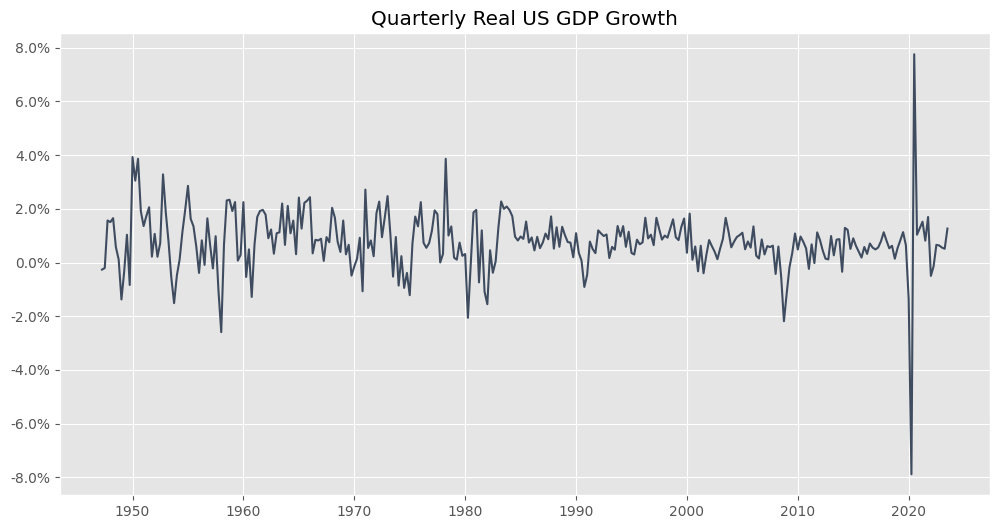

In [32]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(gdp_df['quarterly_growth'])
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter)) # Format the y-axis as percentages
ax.set_title('Quarterly Real US GDP Growth');

Display some summary stats as well:

In [33]:
gdp_df['quarterly_growth'].describe().to_frame()

,quarterly_growth
count,306.000000
mean,0.007717
std,0.011260
min,-0.078910
25%,0.003105
50%,0.007721
75%,0.012623
max,0.077592


What quarters had the lowest and highest GDP changes? 

In [34]:
min_growth = gdp_df['quarterly_growth'].min()
max_growth = gdp_df['quarterly_growth'].max()


min_max_results_df = gdp_df[(gdp_df['quarterly_growth'] == min_growth) | (gdp_df['quarterly_growth'] == max_growth)].copy()

# Add a column to label the min and max values... Just to make it super easy on the eyes:
min_max_results_df.loc[min_max_results_df['quarterly_growth'] == min_growth, 'Label'] = 'Minimum'
min_max_results_df.loc[min_max_results_df['quarterly_growth'] == max_growth, 'Label'] = 'Maximum'

min_max_results_df

,GDPC1,quarterly_growth,Label
date,,,
2020-04-01,19034.830,-0.078910,Minimum
2020-07-01,20511.785,0.077592,Maximum


The minimum and maximum GDP growth rates were when the economy was first entering and exiting COVID. Makes sense.

### Inflation

Inflation is another hot topic right now. Something interesting to note is that when most news articles or commentators are discussing
inflation, they are usually referencing the CPI index. But the Federal Reserve Board of Governors has stated that they
use the PCE index as their preferred gauge of inflation. That feels a little wierd, why the inconsistency? For now, I'll ignore
the *why* behind the discrepancy, and instead use FRED to show that they are basically the same thing:

In [35]:
INFLATION_SERIES = ['CPIAUCSL','PCEPI']
DATA_NAMES = ['CPI','PCE']
inflation_df = get_fred_data(INFLATION_SERIES, DATA_NAMES)

# YoY Inflation Rate:
inflation_df['CPI_YoY'] = inflation_df['CPI'].pct_change(12)
inflation_df['PCE_YoY'] = inflation_df['PCE'].pct_change(12)


# Drop nas:
inflation_df = inflation_df.dropna()
inflation_df

,CPI,PCE,CPI_YoY,PCE_YoY
date,,,,
1960-01-01,29.370,15.421,0.012410,0.016948
1960-02-01,29.410,15.437,0.014138,0.016997
1960-03-01,29.410,15.446,0.015188,0.016920
1960-04-01,29.540,15.502,0.019324,0.018595
1960-05-01,29.570,15.518,0.018251,0.019111
...,...,...,...,...
2023-06-01,303.841,120.221,0.030920,0.031984
2023-07-01,304.348,120.438,0.032991,0.033705
2023-08-01,306.269,120.877,0.037075,0.034109


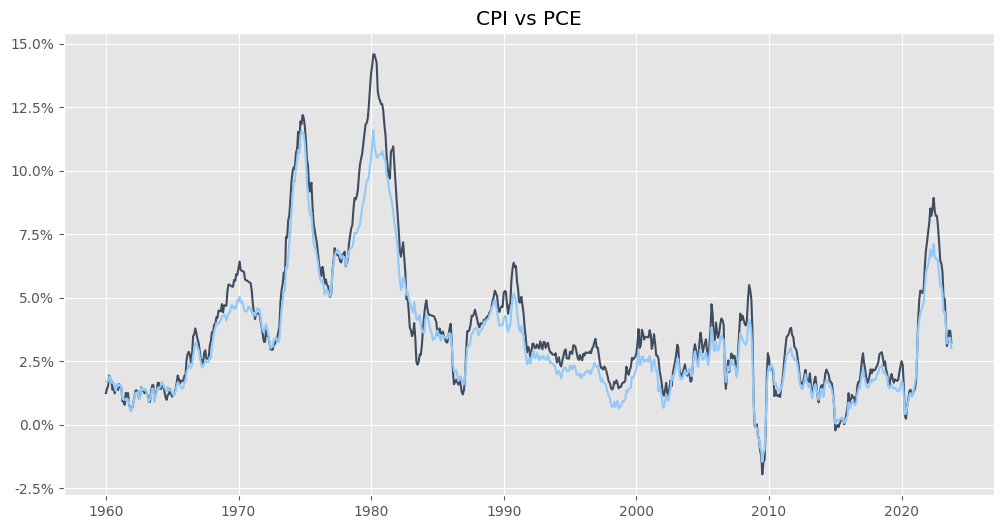

In [36]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(inflation_df['CPI_YoY'], label='CPI ')
ax.plot(inflation_df['PCE_YoY'], label='PCE')
# Format the y axis as a percent:
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
ax.set_title('CPI vs PCE');

So yea, they track each other pretty closely! To be precise and quantitive about exactly how close "pretty close" is, we
can calculate the correlation between the rates of inflation using each index: 

In [37]:
correlation = inflation_df['CPI_YoY'].corr(inflation_df['PCE_YoY'])
print(f"The correlation between CPI and PCE is: {correlation:.2f}")

The correlation between CPI and PCE is: 0.98


### VIX

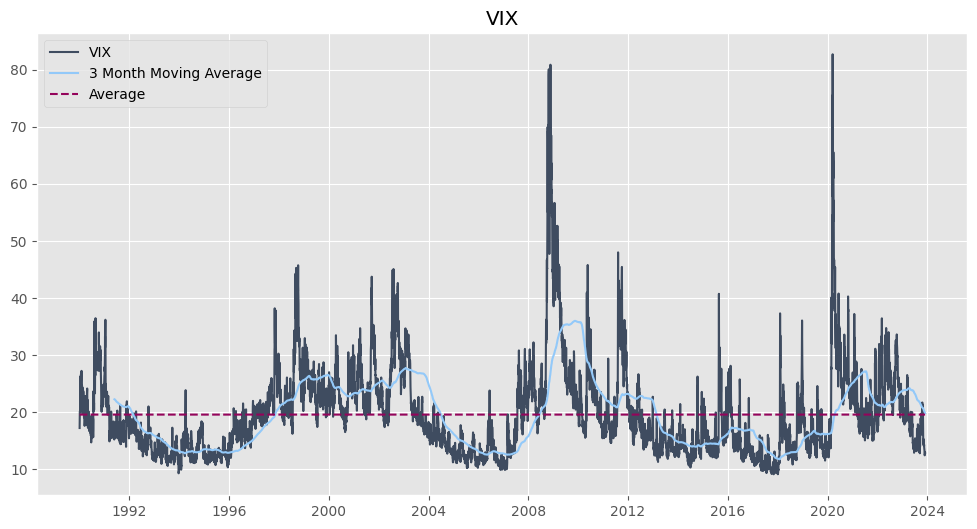

In [38]:
vix_df = get_fred_data('VIXCLS', 'VIX')

# For some reason, there are many missing values in the VIX data, so we will interpolate those:
vix_df['VIX'] = vix_df['VIX'].interpolate()

# Rolling 1 month average:
vix_df['VIX_1M'] = vix_df['VIX'].rolling(22).mean()

# Rolling 3 month average:
vix_df['VIX_3M'] = vix_df['VIX'].rolling(365).mean()

# Entire time period average:
vix_df['VIX_AVG'] = vix_df['VIX'].mean()


# Plot the data: (Not plotting the 1-Month because it follows the actualy number pretty close and the graph is too busy)
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(vix_df['VIX'], label='VIX')
ax.plot(vix_df['VIX_3M'], label='3 Month Moving Average')
ax.plot(vix_df['VIX_AVG'], label='Average', linestyle='--')

ax.set_title('VIX')
ax.legend();

In [39]:
# Display the data:
vix_df

,VIX,VIX_1M,VIX_3M,VIX_AVG
date,,,,
1990-01-02,17.24,NaN,NaN,19.591738
1990-01-03,18.19,NaN,NaN,19.591738
1990-01-04,19.22,NaN,NaN,19.591738
1990-01-05,20.11,NaN,NaN,19.591738
1990-01-08,20.26,NaN,NaN,19.591738
...,...,...,...,...
2023-11-24,12.46,15.317273,19.990603,19.591738
2023-11-27,12.69,14.954091,19.949945,19.591738
2023-11-28,12.69,14.564091,19.909260,19.591738


In [40]:
# Show some basic summary statistics:
vix_df['VIX'].describe().to_frame()

,VIX
count,8848.000000
mean,19.591738
std,7.893034
min,9.140000
25%,13.900000
50%,17.790000
75%,23.010000
max,82.690000


## Future To DO?

* Show how to get unrevised data 